In [1]:
import numpy as np
import cv2
from skimage.segmentation import clear_border

import matplotlib
from matplotlib import pyplot as plt
import os
import seaborn as sns
import sys

#from skimage

In [9]:
%matplotlib inline

#### Comparison between skimage and openCV suggests the use of openCV with optimization (default from installation) http://blog.mmast.net/python-image-processing-libraries-performance-opencv-scipy-scikit-image
#### however skimge seems to have a good clear border feature not available in openCV

home = os.getenv("HOME")
os.chdir('/media/giacomo/CE82DCC682DCB3E5/Users/Giacomo/Documents/gitRepos/bubble_size_analysis/tests')

In [10]:
cd

C:\Users\Giacomo


In [16]:
img = cv2.imread(r'C:\Users\Giacomo\Documents\gitRepos\bubble_size_analysis\drafts\DSC_0392.JPG',-1) # -1 reads the image as is

In [17]:
#channnel separation
img_B,img_G,img_R = cv2.split(img)

In [18]:
#build new image in RGB
img2 = cv2.merge((img_R,img_G,img_B))

In [19]:
sys.getsizeof(img2)

42467392

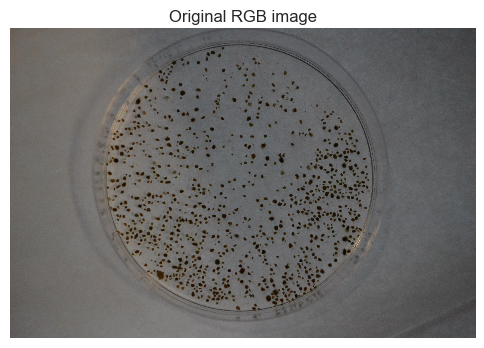

In [20]:
plt.imshow(img2), plt.grid('off'), plt.xticks([]), plt.yticks([]), plt.title('Original RGB image'); #original image
plt.savefig('OriginalRGB')

In [23]:
# here we can select the most contrasting image, in our case is Red channel
plt.figure(figsize=(15, 15))
plt.subplot(1,1,1), plt.imshow(img_B, cmap='gray'), plt.title('Blue ch'), plt.xticks([]), plt.yticks([]); 
#plt.subplot(3,3,2), plt.imshow(img_G, cmap='gray'), plt.title('Green ch'), plt.xticks([]), plt.yticks([]); 
#plt.subplot(3,3,3), plt.imshow(img_R, cmap='gray'), plt.title('Red Ch'), plt.xticks([]), plt.yticks([]); 
#plt.subplot(3,3,4), plt.imshow(img_B, cmap='jet'), plt.xticks([]), plt.yticks([]); 
#plt.subplot(3,3,5), plt.imshow(img_G, cmap='jet'), plt.xticks([]), plt.yticks([]); 
#plt.subplot(3,3,6), plt.imshow(img_R, cmap='jet'), plt.xticks([]), plt.yticks([]); 
##plt.subplot(3,3,7), plt.hist(img_B.ravel(), 256); 
#plt.subplot(3,3,8), plt.hist(img_G.ravel(), 256); 
#plt.subplot(3,3,9), plt.hist(img_R.ravel(), 256);
plt.subplots_adjust(top=0.5); 
#plt.savefig('R_G_B')

MemoryError: 

### Fast solution, but good!
#### Adaptive threshold allows to deal with images having different brightness levels 

In [28]:
# auto thresholding and creating binary image (not used atm)
# http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html
# http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
#binImg = cv2.adaptiveThreshold(img_R, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 91, 18) 
binImg = cv2.adaptiveThreshold(img_R, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 18)

#plt.figure(figsize=(5, 5))
#plt.imshow(binImg), plt.title('Binary image with detected objs'), plt.xticks([]), plt.yticks([]);  # bubbles are zeros!
#plt.savefig('adaptive threshold')

In [31]:
# remove artifacts connected to image border
# somehow works well only starting from white background
dst_inv = cv2.bitwise_not(binImg) # invert image but is no more bynary
img_clb = clear_border(dst_inv, buffer_size=3, bgval=1) # what is touching the 3pixels around the image gets value 1
#this allows easy overlap with original later

#plt.figure(figsize=(15,15))
#plt.subplot(1,2,1)
#plt.imshow(img_clb), plt.title('Cleared border Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.subplot(1,2,2)
#plt.imshow(img_clb-(cv2.bitwise_not(binImg))), plt.title('Showing which bubbles were left out'), 
#plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.savefig('cleared border')

MemoryError: 

Now the images look fine to pass to a bit of erosion before actually measuring


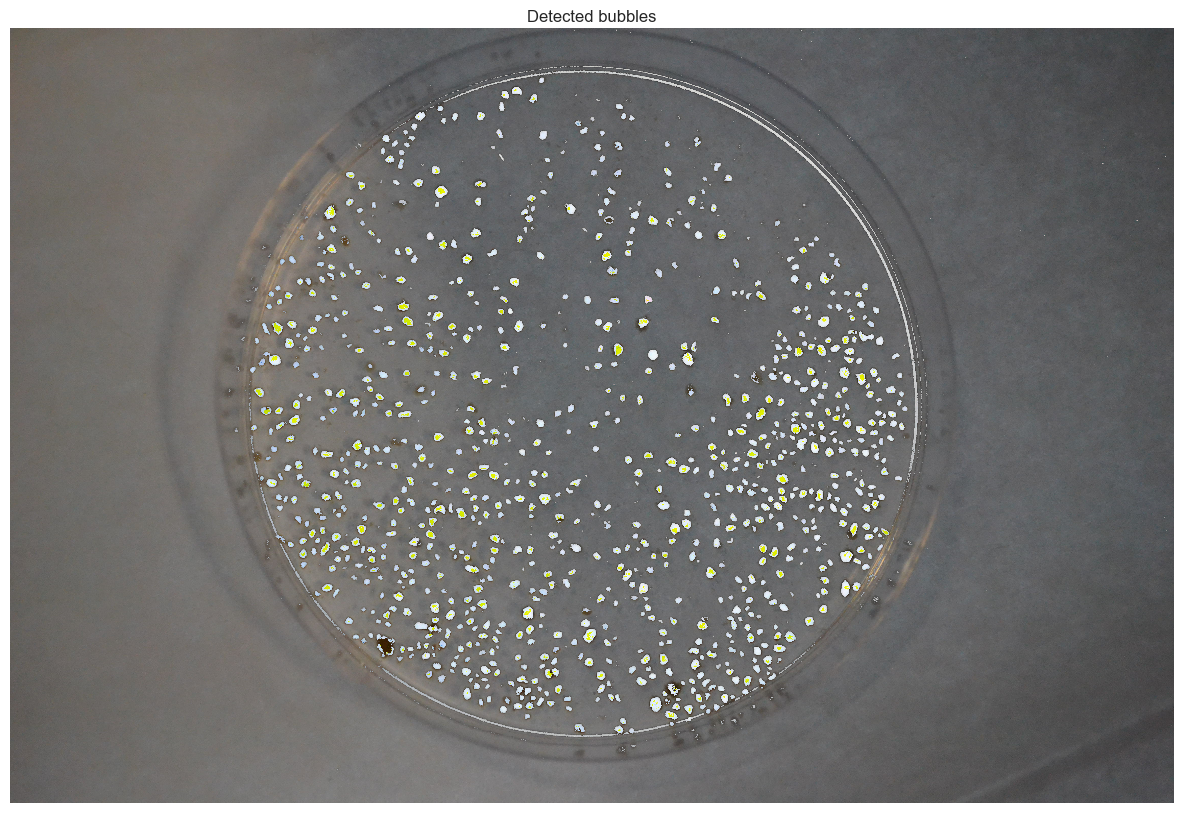

In [30]:
img_outl = cv2.merge((img_R * img_clb, img_G * img_clb, img_B * img_clb))
print "Now the images look fine to pass to a bit of erosion before actually measuring"
plt.figure(figsize=(15, 15));
#plt.subplot(1,2,1) 
plt.imshow(img_outl), plt.title('Detected bubbles'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.subplot(1,2,2) 
#plt.imshow(img2), plt.title('Original Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

MemoryError: 

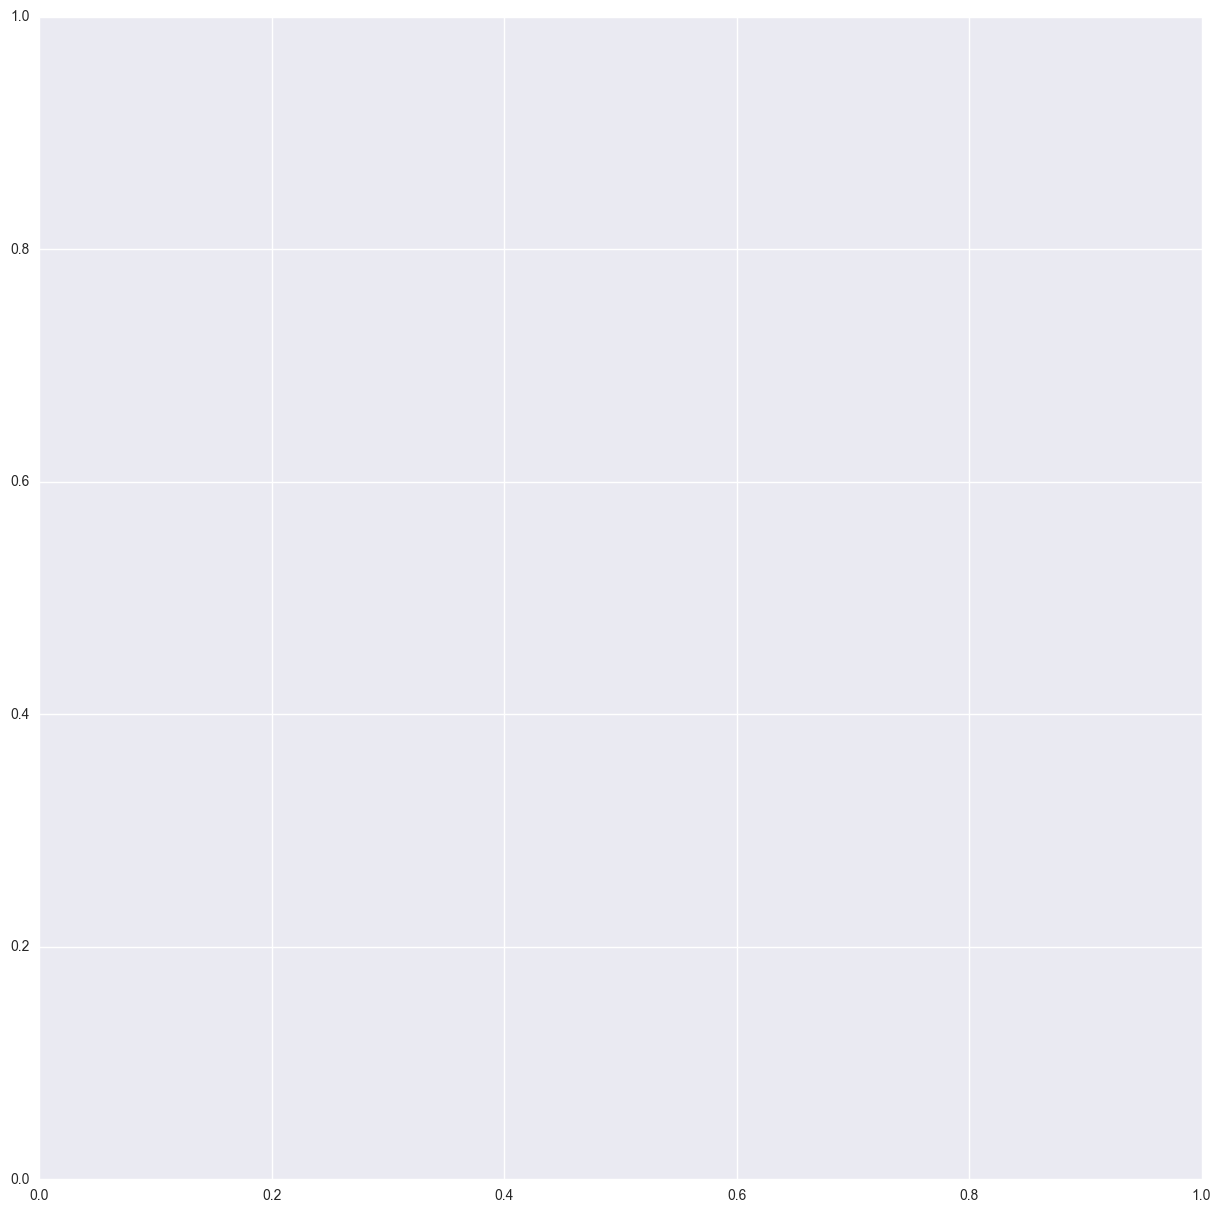

In [32]:
plt.figure(figsize=(15, 15));
plt.imshow(img2), plt.title('Detected bubbles'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

### Let's now go back to the canonical method (canny as thresholding with fixed values, then dilate, erode, etc)
### Edge detection with Canny

In [ ]:
edges = cv2.Canny(img_R, 120, 180) #arguments are min and max thresholds

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1) 
plt.imshow(img_R, cmap = 'gray'), plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(edges, cmap = 'gray'), plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Dilate function

In [ ]:
kernel = np.ones((3,3), np.uint8) # size of the footprint to be left around the bubble
dst = cv2.dilate(edges, kernel, iterations=1);

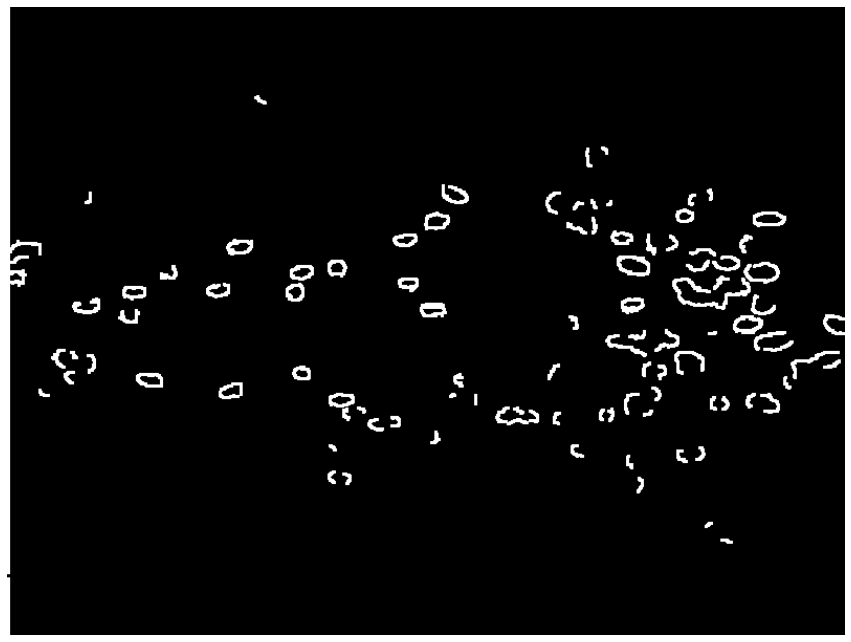

In [15]:
plt.figure(figsize=(15, 15))
plt.imshow(dst, cmap='gray'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

### Fill holes

(<matplotlib.image.AxesImage at 0x7f05e608ab10>,
 None,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

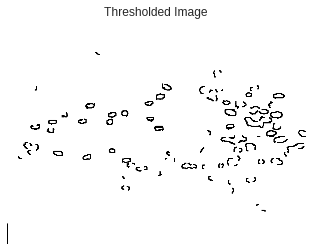

In [16]:
# Filling closed objects

h, w = dst.shape[:2] #stores image sizes
mask = np.zeros((h+2, w+2), np.uint8)
img_flood = cv2.floodFill(dst, mask, (0,0), 0) #STRANGE ENOUGH not only creates the img_flood but also changes dst!? worth posting

# Invert floodfilled image
#dst_inv = cv2.bitwise_not(dst)

# Combine the two images to get the foreground.
#im_out = dst | dst_inv

# Display images
#plt.subplot(2,2,1), 
plt.imshow(dst), plt.title('Thresholded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.subplot(2,2,2), plt.imshow(img_flood), plt.title('Floodfilled Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.subplot(2,2,3), plt.imshow(dst_inv), plt.title('Inverted Floodfilled Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#plt.subplot(2,2,4), plt.imshow(im_out), plt.title('Foreground'), plt.grid('off'), plt.xticks([]), plt.yticks([]);
#cv2.waitKey(0)

### Clear image borders

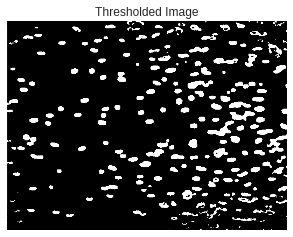

In [17]:
#inversion of bw
dst_inv = cv2.bitwise_not(binImg)
plt.figure(figsize=(5, 5))
plt.imshow(binImg), plt.title('Thresholded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

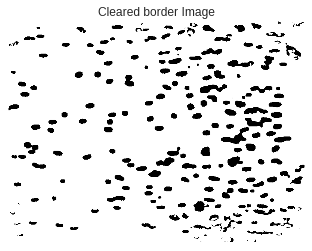

In [19]:
# remove artifacts connected to image border
# somehow works well only starting from white background

img_clb = clear_border(dst_inv, buffer_size=3, bgval=1)

plt.imshow(img_clb), plt.title('Cleared border Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

In [20]:
img_clb

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

#### alternative with iteration on floodfill, less efficient
strt = 0, flg = 0;
iRows = 0, jCols = 0;
while iRows < img.shape[0]
{
    if (flg ==1)
        totalRows = -1;
    Point seed(strt,iRows);     
    iRows++;
    floodFill(dstImg,seed,Scalar (0));
    if (iRows == totalRows)
    {
        flg++;
        iRows = 0;
        strt = totalCols - 1;
    }
}  

### Erode borders

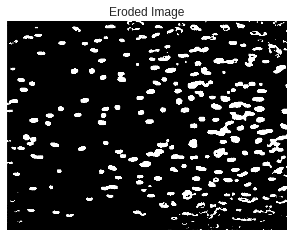

In [21]:
kernel = np.ones((1,1),np.uint8)
erosion = binImg#
cv2.erode(img_clb, kernel, iterations = 1)

plt.figure(figsize=(5, 5))
plt.imshow(erosion), plt.title('Eroded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

### Outlined image

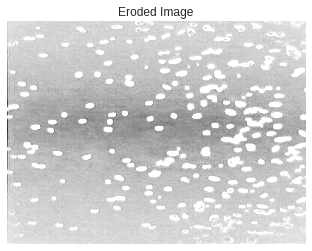

In [22]:
plt.imshow(img_B * erosion), plt.title('Eroded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

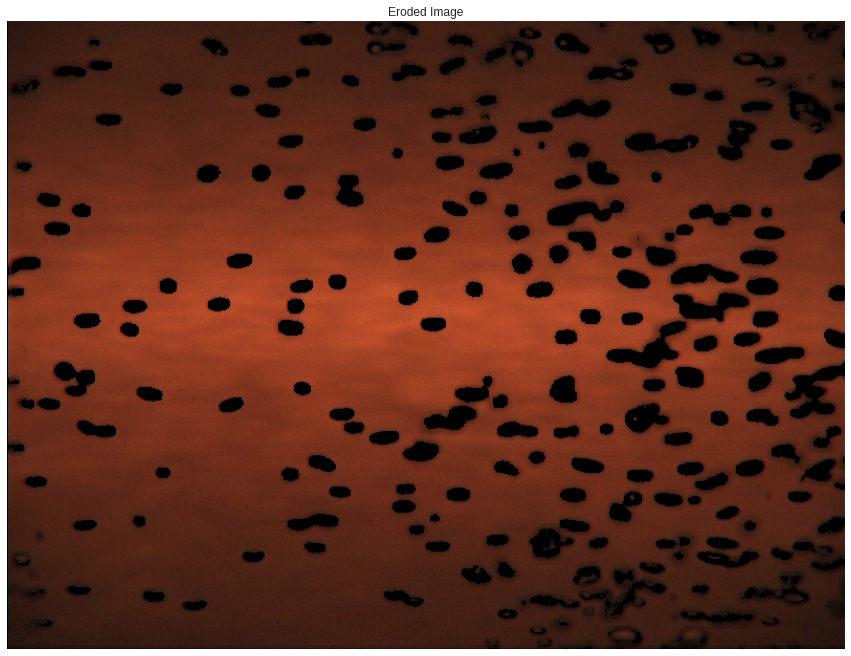

In [23]:
#outlined image with "manual" dilation erosion 
img_outl = cv2.merge((img_R * erosion, img_G * erosion, img_B * erosion))
plt.figure(figsize=(15, 15))
plt.imshow(img_outl), plt.title('Eroded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

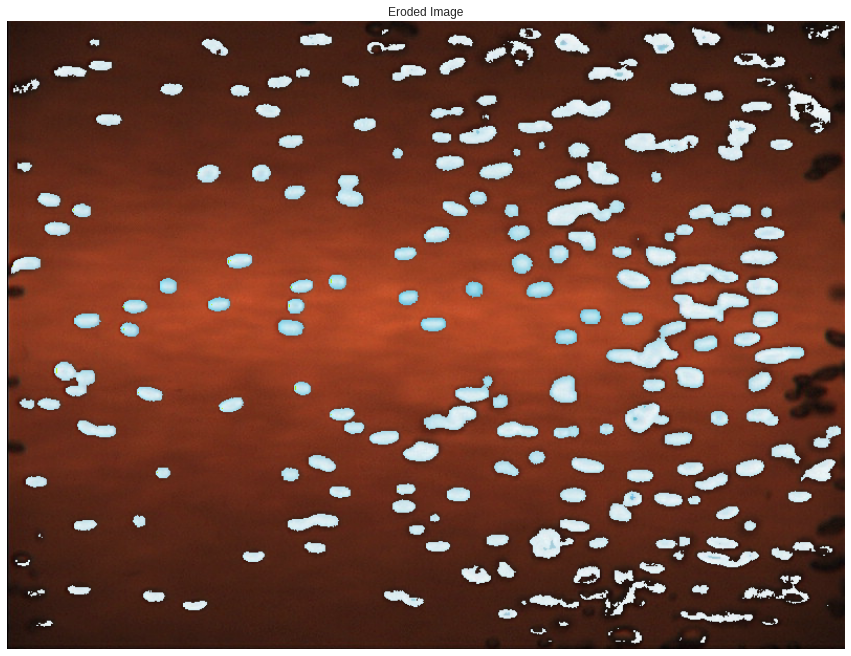

In [24]:
#outlined image without erosion dilation erosion 

img_outl = cv2.merge((img_R * img_clb,img_G* img_clb,img_B* img_clb))
plt.figure(figsize=(15, 15))
plt.imshow(img_outl), plt.title('Eroded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

### Automatic dilate-erode

(<matplotlib.image.AxesImage at 0x7f05dfabdd10>,
 None,
 <matplotlib.text.Text at 0x7f05dedbb490>)

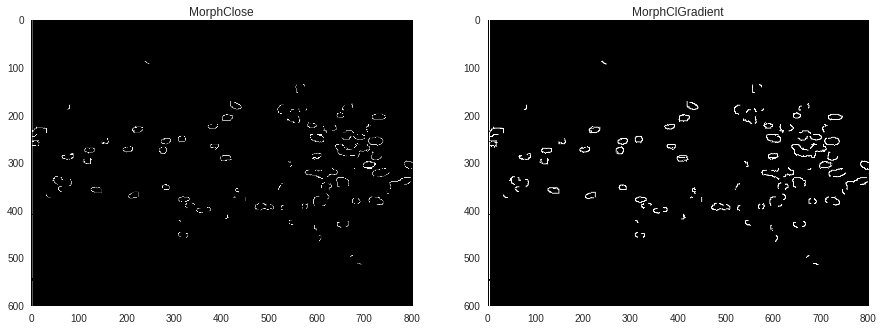

In [25]:
# the sequence of operation and the kernel are important to be balanced
kernel = np.ones((2,2), np.uint8)

#cv2.morphologyEx does erosion and dilation in one shot but seems to result slightly different than donig it separately

#imgopen = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel) # erode -> dilate
imgclose = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) # dilate -> erode
imgclgr = cv2.morphologyEx(imgclose, cv2.MORPH_GRADIENT, kernel) # difference between dilation and erosion
#imgsub = imgclose - imgopen

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
#plt.imshow(imgopen, cmap='gray'), plt.grid('off'); # erosion first 
#plt.subplot(1,4,2)
plt.imshow(imgclose, cmap='gray'), plt.grid('off'), plt.title('MorphClose');
plt.subplot(1,2,2)
plt.imshow(imgclgr, cmap='gray'), plt.grid('off'), plt.title('MorphClGradient');
#plt.subplot(1,4,4)
#plt.imshow(imgsub, cmap='gray'), plt.grid('off');

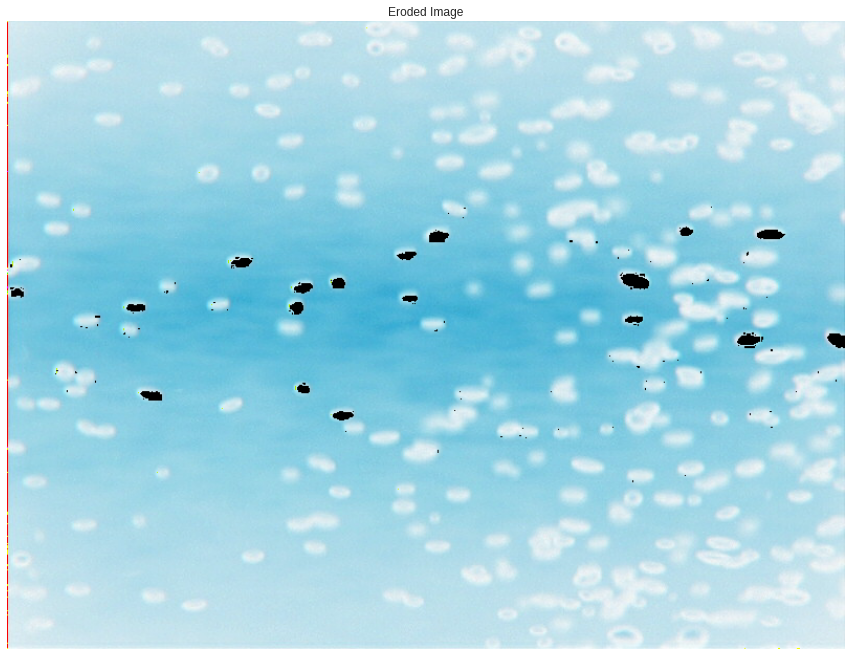

In [26]:
h, w = imgclgr.shape[:2] #stores image sizes
mask = np.zeros((h+2, w+2), np.uint8)
testimg = imgclgr.copy()
cv2.floodFill(testimg, mask, (0,0), 255)

img_outl = cv2.merge((img_R * testimg, img_G * testimg, img_B * testimg))

plt.figure(figsize=(15, 15))
plt.imshow(img_outl), plt.title('Eroded Image'), plt.grid('off'), plt.xticks([]), plt.yticks([]);

### Label objects

In [28]:
ret, markers = cv2.connectedComponents(1-img_clb)

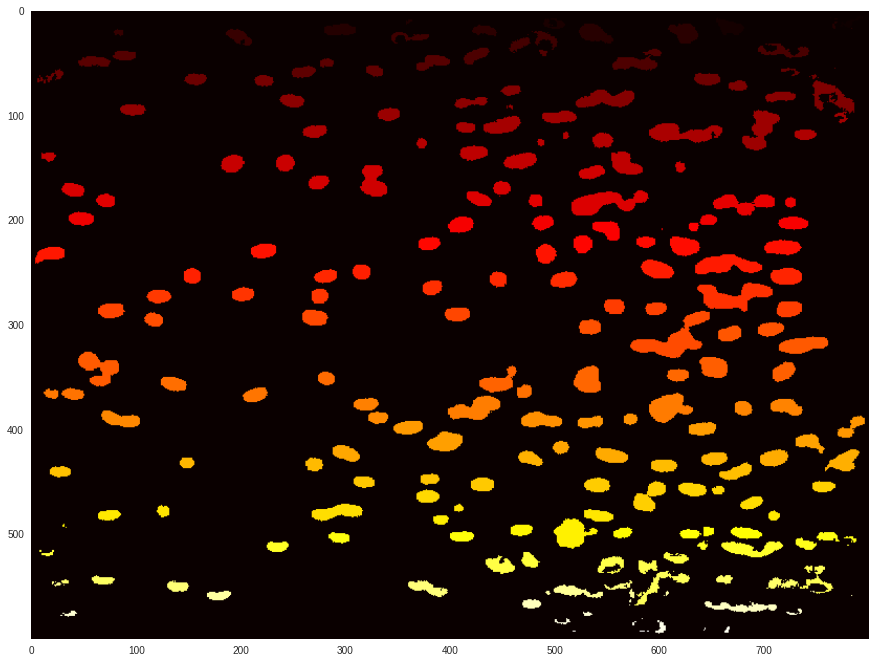

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(markers, cmap='hot'), plt.grid('off') # it doesn't look like but all connected objects are labeled with a different number
plt.savefig('labeled')

### Get objects properties

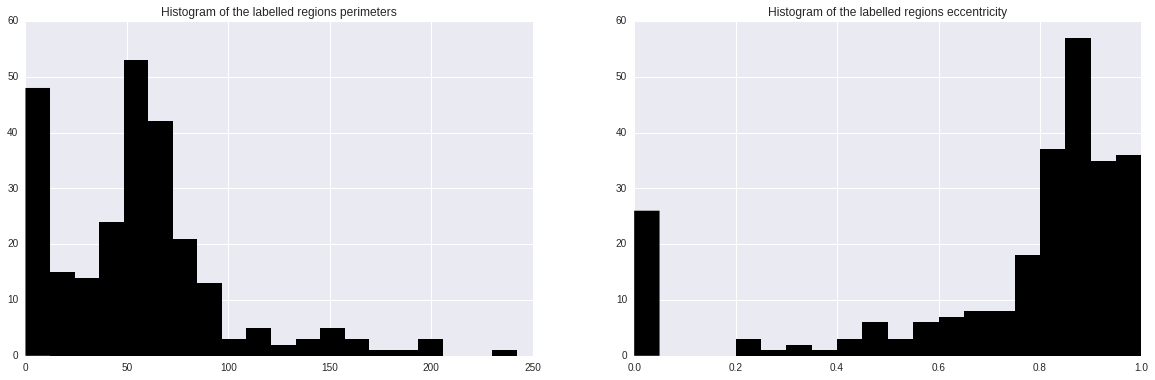

In [30]:
from skimage.measure import subdivide_polygon, regionprops

props = regionprops(markers)#, properties=['area', 'eccentricity','perimeter'])
#many more labels possible
perims = []
eccs = []
for lab in props:
    perims.append(lab['Perimeter'])
    eccs.append(lab['Eccentricity'])

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
tt = ax1.hist(np.array(perims),bins=20,fc='k',ec='none')
ax1.set_title('Histogram of the labelled regions perimeters')
ax2 = fig.add_subplot(122)
tt = ax2.hist(np.array(eccs),bins=20,fc='k',ec='none')
ax2.set_title('Histogram of the labelled regions eccentricity')

In [20]:
props

#### Simple blob detector, seems to work only for grayscale images, too simple. It's made to start with little preprocessing
##### We want to work with our binary image which we already prepared for blob detection. Basically we want a simpler method :)

In [234]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 0;
params.thresholdStep = 0.1;
params.maxThreshold = 255;
 
# Filter by Area.
params.filterByArea = False
params.minArea = 15
 
# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.17
 
# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01
 
# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

In [235]:
# Detect blobs.
keypoints = detector.detect(1-img_clb)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(1-img_clb, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Show keypoints
plt.figure(figsize=(15,15))
plt.imshow(im_with_keypoints), plt.title('Keypoints'), plt.grid('off');

error: ..\..\..\modules\features2d\src\blobdetector.cpp:315: error: (-210) Blob detector only supports 8-bit images! in function cv::SimpleBlobDetectorImpl::detect


# Possible alternatives/improvements (?)

### scikit image 

In [67]:
from skimage.morphology import reconstruction #ci mette un sacco a caricare

In [68]:
seed = np.copy(img_R)
seed[1:-1, 1:-1] = img_R.min()
mask = img_R

dilated = reconstruction(seed, mask, method='dilation')

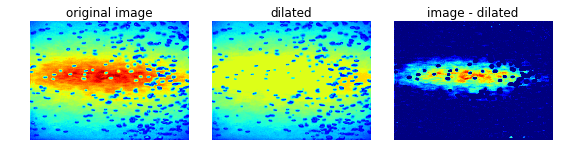

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5), sharex=True, sharey=True)

ax1.imshow(img_R)
ax1.set_title('original image')
ax1.axis('off')
ax1.set_adjustable('box-forced')

ax2.imshow(dilated, vmin=img_R.min(), vmax=img_R.max())
ax2.set_title('dilated')
ax2.axis('off')
ax2.set_adjustable('box-forced')

ax3.imshow(img_R - dilated)
ax3.set_title('image - dilated')
ax3.axis('off')
ax3.set_adjustable('box-forced')

fig.tight_layout()

In [74]:
h = 0.4
seed = img_R - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = img_R - dilated

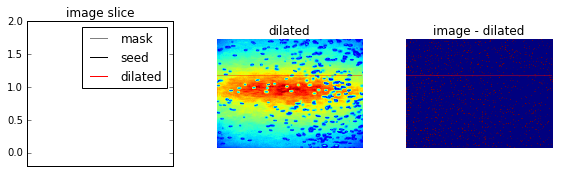

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))

yslice = 197

ax1.plot(mask[yslice], '0.5', label='mask')
ax1.plot(seed[yslice], 'k', label='seed')
ax1.plot(dilated[yslice], 'r', label='dilated')
ax1.set_ylim(-0.2, 2)
ax1.set_title('image slice')
ax1.set_xticks([])
ax1.legend()

ax2.imshow(dilated, vmin=img_R.min(), vmax=img_R.max())
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('dilated')
ax2.axis('off')

ax3.imshow(hdome)
ax3.axhline(yslice, color='r', alpha=0.4)
ax3.set_title('image - dilated')
ax3.axis('off')

fig.tight_layout()
plt.show()

#### in this case the trick original image minus dilated do not work well

### Otsu's thresholding, potentially applicable to powerup Canny http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html

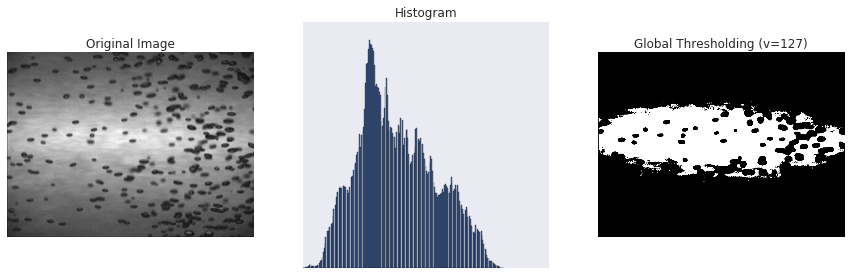

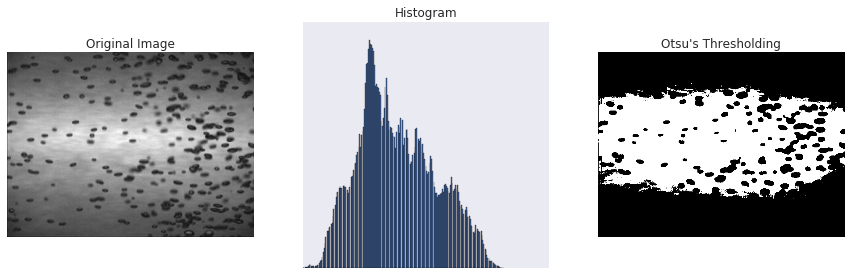

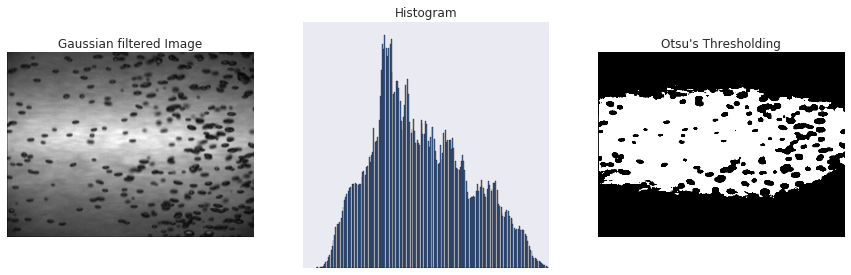

In [99]:
# global thresholding
ret1,th1 = cv2.threshold(img_R, 127, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img_R,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img_R,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img_R, 0, th1,
          img_R, 0, th2,
          blur, 0, th3]
titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in xrange(3):
    plt.figure(figsize=(15,15))
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
    plt.show()

### blob detector https://www.learnopencv.com/blob-detection-using-opencv-python-c/

In [18]:
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector()
 
# Detect blobs
keypoints = detector.detect(img_R)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img_R, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)

error: -------src-dir-------/opencv-2.4.10/modules/highgui/src/window.cpp:501: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage


In [170]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 1500
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01
 
# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

## use watershed

In [15]:
gray = img_R
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

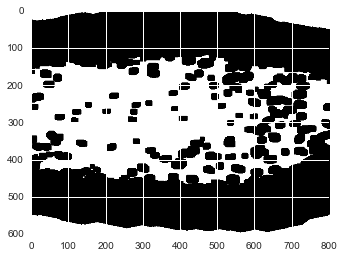

In [81]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
plt.imshow(sure_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = sure_fg - sure_bg
plt.imshow(unknown)

In [82]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

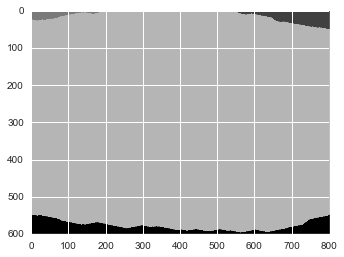

In [83]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(markers)

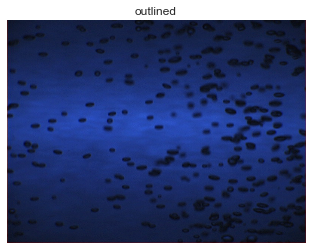

In [84]:
 plt.imshow(img), plt.title('outlined'), plt.xticks([]), plt.yticks([]);